In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install --upgrade transformers datasets

In [ ]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.17.1
1.26.4
4.47.1
3.2.0


In [ ]:
from datasets import load_dataset

# NSMC 데이터셋 로드
dataset = load_dataset("nsmc")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

nsmc.py:   0%|          | 0.00/3.18k [00:00<?, ?B/s]

The repository for nsmc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nsmc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig

# KLUE/BERT-Base 모델과 Tokenizer 로드
model_name = "klue/bert-base"
config = AutoConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.3  # 드롭아웃
config.attention_probs_dropout_prob = 0.3  # 어텐션 드롭아웃

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config) # NSMC 영화 리뷰 긍정/부정 이진 분류

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import Counter
print("Train :",Counter(dataset['train']['label']))
print("Test :",Counter(dataset['test']['label']))

Train : Counter({0: 75173, 1: 74827})
Test : Counter({1: 25173, 0: 24827})


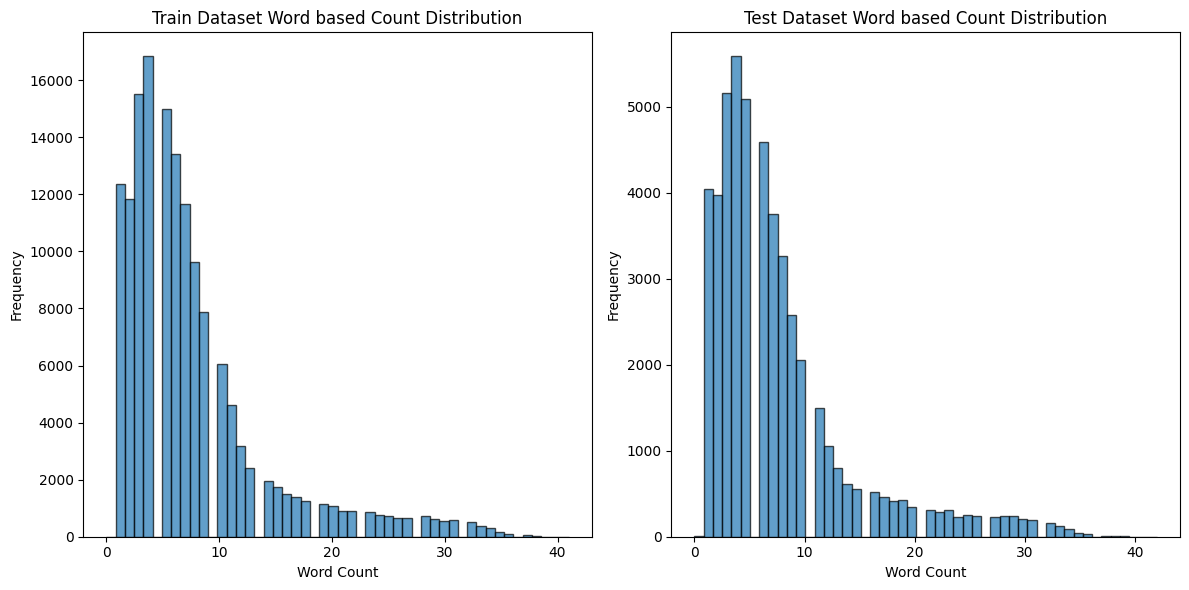

Train Max : 41
Test Max : 42


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# 공백 제외
def count_words(text):
    return len(text.split())

# 단어 기준
train_df['word_count'] = train_df['document'].apply(count_words)
test_df['word_count'] = test_df['document'].apply(count_words)

# 분포 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_df['word_count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Train Dataset Word based Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_df['word_count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Test Dataset Word based Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# max length
print("Train Max :",train_df['word_count'].max())
print("Test Max :",test_df['word_count'].max())

In [ ]:
# Tokenizer를 사용해 데이터셋 전처리
def preprocess_function(examples):
    return tokenizer(examples["document"], truncation=True, padding="max_length", max_length=128)

# train
train_dataset = dataset["train"].map(preprocess_function, batched=True)

# val
val_dataset = dataset["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

# DataCollator: 데이터를 미니배치로 패딩
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 평가 지표
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)  # argmax
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    save_total_limit=2,  # 체크포인트 최대 2개만 (처음 & 마지막 일듯)
    save_strategy="epoch",  # 매 에포크마다 체크포인트
    load_best_model_at_end=True,
)

# Trainer 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,  # acc 함수
)

# 모델 학습
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-8d94bc82e8c3>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.288700,0.283125,0.893060,0.880537,0.911214,0.895613


In [ ]:
from datasets import Dataset
import numpy as np

In [ ]:


# 저장된 가중치 경로
checkpoint_path = "/content/results/checkpoint-18750"
# 모델 및 Tokenizer 로드
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)  # config는 자동으로 로드됨

# NSMC 데이터셋 로드 및 전처리
dataset = load_dataset("nsmc")

def preprocess_function(examples):
    return tokenizer(
        examples["document"], truncation=True, padding="max_length", max_length=128
    )

# `val_dataset` 생성
val_dataset = dataset["test"].map(preprocess_function, batched=True)

# 평가 함수 정의
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Trainer 설정
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=64,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 평가
results = trainer.evaluate()

print("Evaluation Results:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall: {results['eval_recall']:.4f}")
print(f"F1: {results['eval_f1']:.4f}")

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

<ipython-input-20-c3a392ac3977>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation Results:
Accuracy: 0.8977
Precision: 0.8812
Recall: 0.9210
F1: 0.9007


In [ ]:
from transformers import TrainingArguments, Trainer

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,  # 총 3 에폭으로 설정
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=False,  # 최적 모델 로드 대신 이어서 학습
)

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"].map(preprocess_function, batched=True),
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 학습 수행 (체크포인트에서 시작)
trainer.train(resume_from_checkpoint=checkpoint_path)

# 학습 완료 후 평가 수행
results = trainer.evaluate()

# 결과 출력
print("Evaluation Results After Additional Training:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall: {results['eval_recall']:.4f}")
print(f"F1: {results['eval_f1']:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-22-670a82ec5a7f>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary obj

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
3,0.232400,0.295909,0.899160,0.880563,0.925198,0.902328


Evaluation Results After Additional Training:
Accuracy: 0.8992
Precision: 0.8806
Recall: 0.9252
F1: 0.9023


In [ ]:
# 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/goingdeeperGD8/checkpoint-28125"

# 모델과 토크나이저 로드
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# TrainingArguments 설정
training_args = TrainingArguments(
    output_dir="./results",  # 체크포인트 저장 경로
    evaluation_strategy="epoch",  # 매 에폭마다 평가
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,  # 총 4 에폭 학습
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=False  # 최적 모델 대신 이어서 학습
)

# 평가 함수 설정
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    import numpy as np
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Validation 데이터셋 추가
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 학습 수행 (체크포인트에서 시작)
trainer.train(resume_from_checkpoint=checkpoint_path)

# 학습 완료 후 모델 저장
trainer.save_model("/content/drive/MyDrive/checkpoint-4epoch")  # 4 에폭 학습된 모델 저장

# 학습 후 Validation 데이터셋 평가
results = trainer.evaluate()

# 결과 출력
print("Evaluation Results After Training:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Precision: {results['eval_precision']:.4f}")
print(f"Recall: {results['eval_recall']:.4f}")
print(f"F1: {results['eval_f1']:.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-14-534f338791f4>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary obj

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3083: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rng_state = torch.load(rng_file)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
4,0.209700,0.306837,0.900160,0.879842,0.928495,0.903514


Evaluation Results After Training:
Accuracy: 0.9002
Precision: 0.8798
Recall: 0.9285
F1: 0.9035


In [ ]:
# val 데이터셋에서 정성평가
predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# 실제 라벨 !=  예측 라벨
mismatched_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]

mismatched_data = pd.DataFrame({
    "document": [val_dataset[i]["document"] for i in mismatched_indices],
    "true_label": [true_labels[i] for i in mismatched_indices],
    "predicted_label": [predicted_labels[i] for i in mismatched_indices]
})

#### val set 자체는 5만개에 분포 역시 train 셋과 별 차이 없으므로 바로 test로 넘어가도 큰 문제는 없을 것 - 정성 평가 필요
#### 데이터 라벨 자체가 잘못된 경우가 꽤 있다.
#### klue/Roberta 의 경우 더 빠르게 acc 90%를 달성한다.